# 10-9. 프로젝트: CAM을 만들고 평가해 보자

## CAM 구현하기

1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [4]:
# 최초 수행시에는 다운로드가 진행
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

 * 이미지의 클래스와 인덱스 확인

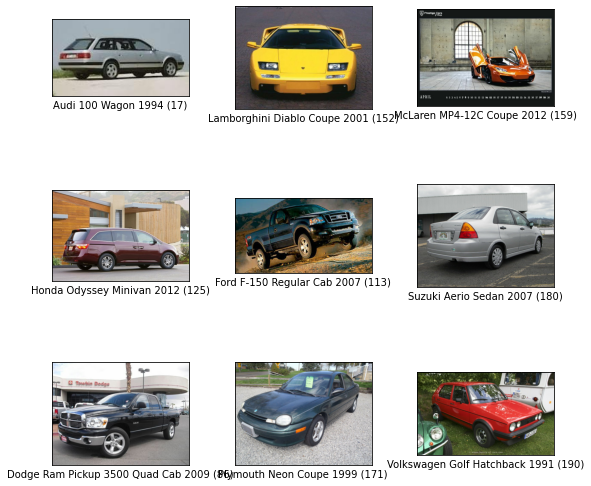

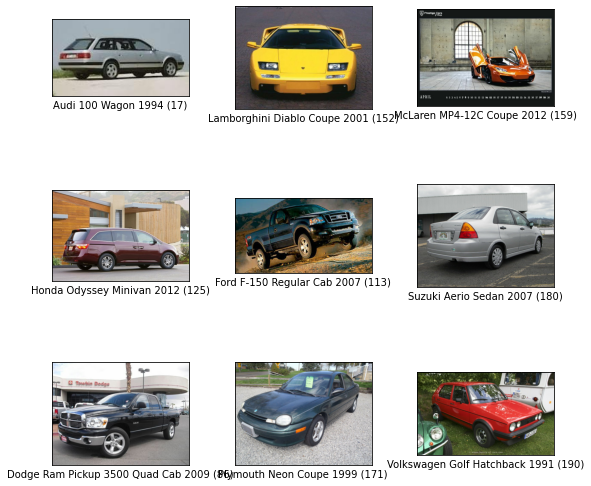

In [6]:
tfds.show_examples(ds_train, ds_info)

 * 테스트옹 데이터셋

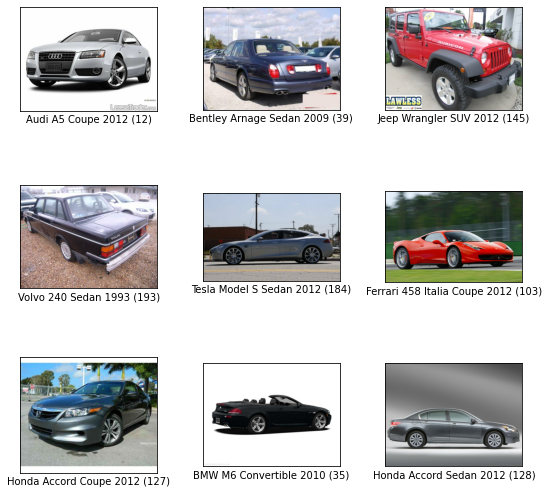

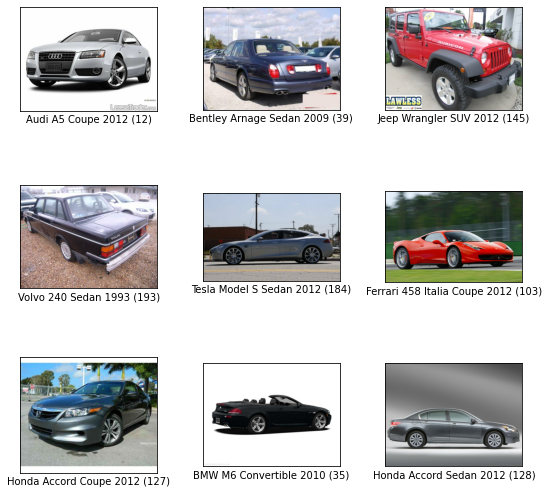

In [7]:
tfds.show_examples(ds_test, ds_info)

* df_info를 조회해 features가 어떻게 구성되어 있는지 확인

In [8]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

 * bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법
 * BBoxFeature이라는 타입으로 정의
     - https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature
     
     
     바운딩 박스를 표시하는 방법들

* 'xywh'
    * 'xywh'는 바운딩박스 중심점을 x, y로 표기하고,0
    * 사각형의 너비 w와 높이 h를 표기하는 방법
    * (예) (x_center, y_center, width, height) 
    * x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있음 
    
    
* 'minmax'
    * 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법
    * (예) (x_min, x_max, y_min, y_max) 
    * 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적
    
    
* 위 두가지 뿐만 아니라 
    * 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 
    * 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 
    * 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있음

해당 bounding box는 minmax를 의미
tfds의 경우 height를 첫번째 axis로 삼고있어 [minY, minX, maxY, maxX]를 의미

 ### 모델 만들기

In [10]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

 * CAM 모델 확인

In [11]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [12]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [14]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [15]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 93s 182ms/step - loss: 4.1815 - accuracy: 0.1686 - val_loss: 5.3798 - val_accuracy: 0.0059
Epoch 2/15
509/509 [==============================] - 78s 154ms/step - loss: 1.6584 - accuracy: 0.6367 - val_loss: 2.2193 - val_accuracy: 0.4454
Epoch 3/15
509/509 [==============================] - 79s 154ms/step - loss: 0.5642 - accuracy: 0.8987 - val_loss: 1.2976 - val_accuracy: 0.6612
Epoch 4/15
509/509 [==============================] - 79s 155ms/step - loss: 0.1698 - accuracy: 0.9831 - val_loss: 1.1106 - val_accuracy: 0.7100
Epoch 5/15
509/509 [==============================] - 79s 155ms/step - loss: 0.0541 - accuracy: 0.9975 - val_loss: 1.0561 - val_accuracy: 0.7198
Epoch 6/15
509/509 [==============================] - 79s 155ms/step - loss: 0.0384 - accuracy: 0.9983 - val_loss: 1.0189 - val_accuracy: 0.7303
Epoch 7/15
509/509 [==============================] - 79s 155ms/step - loss: 0.0333 - accuracy: 0.9982 - val_loss: 1.0261 - val_ac

 * 학습시킨 가중치를 저장

In [16]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

In [19]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [20]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

 * 함수 실행

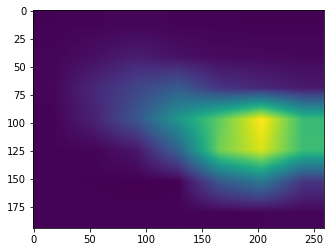

In [21]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

 * 그려진 CAM 이미지를 원본에 합치기

In [22]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

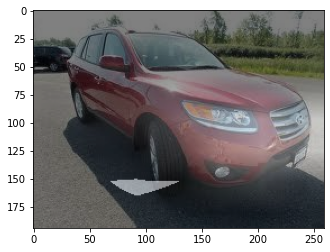

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

    * 새로운 이미지 뽑아보기

145


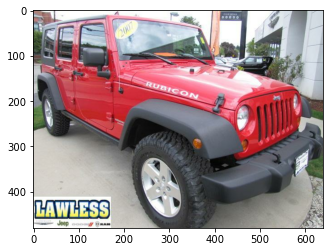

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [25]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측 값 구하기
        output = conv_output[0] # 원하는 layer의 output 구하기
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient 구하기

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구하기
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map 얻기
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

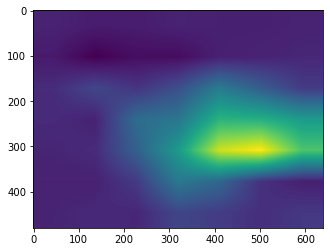

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

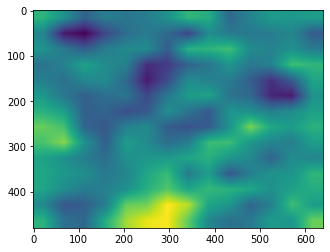

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

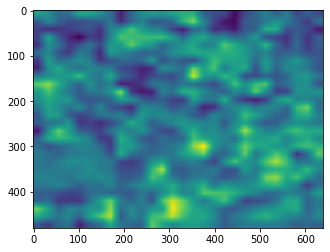

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## 바운딩 박스 구하기

1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

141


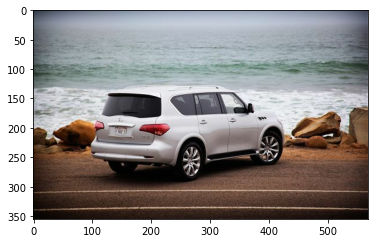

In [29]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

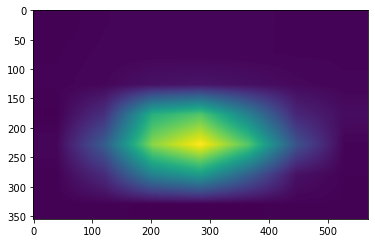

In [30]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이전의 generate_cam을 활용해서 CAM 이미지를 뽑아봅시다. 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 int 자료형으로 변환해 줍니다.

In [31]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

 * bbox를 얻고 이미지로 바운딩 박스를 얻는 모습을 볼 수 있음

In [32]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 52, 323],
       [ 52, 126],
       [512, 126],
       [512, 323]])

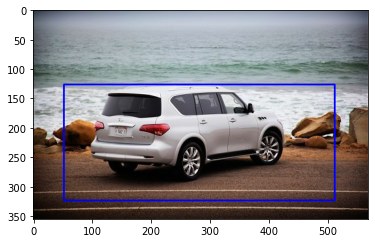

In [33]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

## IoU 구하기

1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [37]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [38]:
get_iou(pred_bbox, item['bbox'])

0.6077181111827641